## Imports

In [39]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as T
import bcolz
import time
from torch.utils.data import Dataset, DataLoader, sampler
%matplotlib inline

In [40]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

def gpu(x,use_gpu=use_gpu):
    if use_gpu:
        return x.cuda()
    else:
        return x

Using gpu: True 


## Data processing

In [41]:
data_dir = './Dataset'

transform = T.Compose([
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dsets = {x: dset.ImageFolder(os.path.join(data_dir, x), transform=transform)
         for x in ['train', 'val', 'test']}

train_dataset = dset.ImageFolder('./Dataset/train', transform=transform)
val_dataset = dset.ImageFolder('./Dataset/val', transform=transform)
test_dataset = dset.ImageFolder('./Dataset/test', transform=transform)

In [42]:
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)
print("Number of training examples {}, validation examples {}, testing examples {}".format(train_size, val_size, test_size))

Number of training examples 66071, validation examples 11016, testing examples 33154


In [43]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=6)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=6)

## Creating VGG model

In [44]:
model = models.vgg16(pretrained=True)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [45]:
for param in model.parameters():
    param.requires_grad = False
model.classifier._modules['6'] = nn.Linear(4096, 172)
# model.classifier._modules['7'] = torch.nn.LogSoftmax(dim = 1)

In [46]:
print(model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=172, bias=True)
)


In [47]:
model = gpu(model)

## Training fully connected module

In [48]:
def load_array(fname):
    return bcolz.open(fname)[:]

### Loading Preconvoluted features

In [49]:
conv_feat_val = load_array('./vgg16/feat_val.bc')
labels_val = load_array('./vgg16/labels_val.bc')

In [50]:
print(len(conv_feat_val))
print(conv_feat_val.shape)

11016
(11016, 512, 7, 7)


In [51]:
optimizer = optim.Adam(model.parameters())

### Creating Data generator

In [52]:
def data_gen(conv_feat,labels,batch_size=64,shuffle=True):
    labels = np.array(labels)
    if shuffle:
        index = np.random.permutation(len(conv_feat))
        conv_feat = conv_feat[index]
        labels = labels[index]
    for idx in range(0,len(conv_feat),batch_size):
        yield(conv_feat[idx:idx+batch_size],labels[idx:idx+batch_size])

In [53]:
def data_gen_train():
    for i in range(0, 11):
        conv_feat = load_array('./vgg16/feat_train_{}.bc'.format(i))
        labels = load_array('./vgg16/labels_train_{}.bc'.format(i))
        yield from data_gen(conv_feat, labels)

### Training the model

In [54]:
def train_model(model, optimizer, conv_feat_val, labels_val, epochs=1):
    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    for epoch in range(epochs):
        model.train()
        batches = data_gen_train()
        num_correct, num_samples, total_loss = 0, 0, 0
        running_corrects = 0
        for x, y in batches:
            x, y = gpu(torch.from_numpy(x)), gpu(torch.from_numpy(y))
            x = x.view(x.size(0), -1)
            scores = model(x)
            loss = F.cross_entropy(scores, y)           
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,preds = torch.max(scores.data,1)
            total_loss += loss.data.item()
            num_correct += torch.sum(preds == y.data)
            num_samples += preds.size(0)
        average_loss = total_loss / num_samples
        acc = num_correct / num_samples
        train_loss_history.append(average_loss)
        train_accuracy_history.append(acc)
        print('Epoch: {} Training Loss: {:.4f} Got {} / {} correct. Acc: {:.2f}%'.format(
                     epoch + 1, average_loss, num_correct, num_samples, 100 * acc))
        
        check_accuracy(model, conv_feat_val, labels_val, val_loss_history, val_accuracy_history, epoch)
    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history

def check_accuracy(model, conv_feat_val, labels_val, val_loss_history, val_accuracy_history, epoch):
    num_correct, num_samples, total_loss = 0, 0, 0
    model.eval()
    batches = data_gen(conv_feat=conv_feat_val, labels=labels_val)
    with torch.no_grad():
        for x, y in batches:
            x, y = gpu(torch.from_numpy(x)), gpu(torch.from_numpy(y))                
            x = x.view(x.size(0), -1)
            scores = model(x)
            loss = F.cross_entropy(scores, y) 
            _, preds = torch.max(scores.data, 1)
            total_loss += loss.data.item()
            num_correct += torch.sum(preds == y.data)
            num_samples += preds.size(0)
        average_loss = total_loss / num_samples
        acc = num_correct / num_samples
    val_loss_history.append(average_loss)
    val_accuracy_history.append(acc)
    print('Epoch: {} Validation Loss: {:.4f} Got {} / {} correct {:.2f}%'.format(
        epoch + 1, average_loss, num_correct, num_samples, 100 * acc))
        

In [55]:
%%time
LOSS, ACC, LOSS_V, ACC_V = train_model(gpu(model.classifier), optimizer, conv_feat_val, labels_val, epochs=50)

Epoch: 1 Training Loss: 0.0399 Got 26406 / 66071 correct. Acc: 39.97%
Epoch: 1 Validation Loss: 0.0281 Got 5901 / 11016 correct 53.57%
Epoch: 2 Training Loss: 0.0344 Got 31272 / 66071 correct. Acc: 47.33%
Epoch: 2 Validation Loss: 0.0272 Got 6130 / 11016 correct 55.65%


KeyboardInterrupt: 

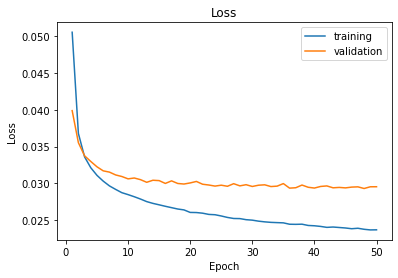

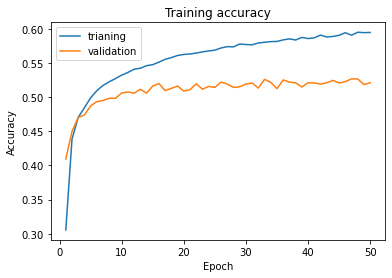

In [37]:
plt.figure()
E = np.arange(50)+1
plt.plot(E,LOSS,label='training')
plt.plot(E,LOSS_V,label='validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(E,ACC,label='training')
plt.plot(E,ACC_V,label='validation')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training accuracy")
plt.legend()
plt.show()

In [38]:
correct = 0
total = 0
with torch.no_grad():
    for data in dset_loaders['test']:
        images, labels = data
        images = gpu(images)
        labels = gpu(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the all test images: %d %%' % (
    100 * correct / total))

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of the network on the all test images: 51 %
